In [1]:
import numpy as np
import pandas as pd
import yfinance
import statsmodels.formula.api as smf
import statsmodels.api as smi
from table_making import summary_col
import matplotlib.pyplot as plt
import re
import os

In [2]:
if not os.path.exists("tables"):
    os.makedirs("tables")
if not os.path.exists("tables/no_ex"):
    os.makedirs("tables/no_ex")
if not os.path.exists("tables/no_loss"):
    os.makedirs("tables/no_loss")
if not os.path.exists("tables/loss"):
    os.makedirs("tables/loss")

# Function and constant definitions

In [3]:
periods = [
    ("2000-2002", "Dot-Com Bubble Burst and Post-Crisis Recovery", pd.date_range("2000-01-06", "2002-12-31")),
    ("2003-2007", "Pre-Financial Crisis Growth", pd.date_range("2003-01-01", "2007-12-31")),
    ("2008-2009", "Global Financial Crisis", pd.date_range("2008-01-01", "2009-12-31")),
    ("2010-2014", "Post-Crisis Stability and Expansion", pd.date_range("2010-01-01", "2014-12-31")),
    ("2015-2019", "Late-Decade Dynamics", pd.date_range("2015-01-01", "2019-12-31")),
    ("2020-2021", "Covid Impact", pd.date_range("2020-01-01", "2021-12-31"))
]

num_subplots = len(periods)
num_cols = min(num_subplots, 3)
num_rows = (num_subplots + num_cols - 1) // num_cols

In [4]:
def latex_format(sm):
    ltx = sm.as_latex()
    ltx = re.sub(r" +", " ", ltx)
    ltx = ltx.replace("& 2000-2002\\_VIX & 2003-2007\\_VIX & 2008-2009\\_VIX & 2010-2014\\_VIX & 2015-2019\\_VIX & 2020-2021\\_VIX \\\\\n\\hline", 
""" & 2000-2002 & 2003-2007 & 2008-2009 & 2010-2014 & 2015-2019 & 2020-2021 \\\\
 & (1) & (2) & (3) & (4) & (5) & (6) \\\\
\cmidrule(lr){2-2} \cmidrule(lr){3-3} \cmidrule(lr){4-4} \cmidrule(lr){5-5} \cmidrule(lr){6-6} \cmidrule(lr){7-7}""")
    ltx = ltx.replace("& 2000-2002\\_abs\\_delta\\_VIX & 2003-2007\\_abs\\_delta\\_VIX & 2008-2009\\_abs\\_delta\\_VIX & 2010-2014\\_abs\\_delta\\_VIX & 2015-2019\\_abs\\_delta\\_VIX & 2020-2021\\_abs\\_delta\\_VIX \\\\\n\\hline",
""" & 2000-2002 & 2003-2007 & 2008-2009 & 2010-2014 & 2015-2019 & 2020-2021 \\\\
 & (1) & (2) & (3) & (4) & (5) & (6) \\\\
\cmidrule(lr){2-2} \cmidrule(lr){3-3} \cmidrule(lr){4-4} \cmidrule(lr){5-5} \cmidrule(lr){6-6} \cmidrule(lr){7-7}""")
    ltx = ltx.replace("iv\_atm\_std", "$\sigma(\\text{iv}_{\\text{ATM}})$")
    ltx = ltx.replace("iv\_atm\_mean", "$\mu(\\text{iv}_{\\text{ATM}})$")
    ltx = ltx.replace("R-squared Adj.", "\\hline\n$R^2$")
    ltx = ltx.replace("\\$N\\$", "$N$")
    ltx = ltx.replace("""lllllll""", """lcccccc""")
    ltx = ltx.replace("cc}\n\\hline", "cc}\n\\hline\\hline")
    ltx = ltx.replace("\\begin{table}\n\\caption{}\n\\label{}\n\\begin{center}\n", "")
    ltx = ltx.replace("\\end{center}\n\\end{table}", "")
    return ltx

# Regression - no ex feats

## std

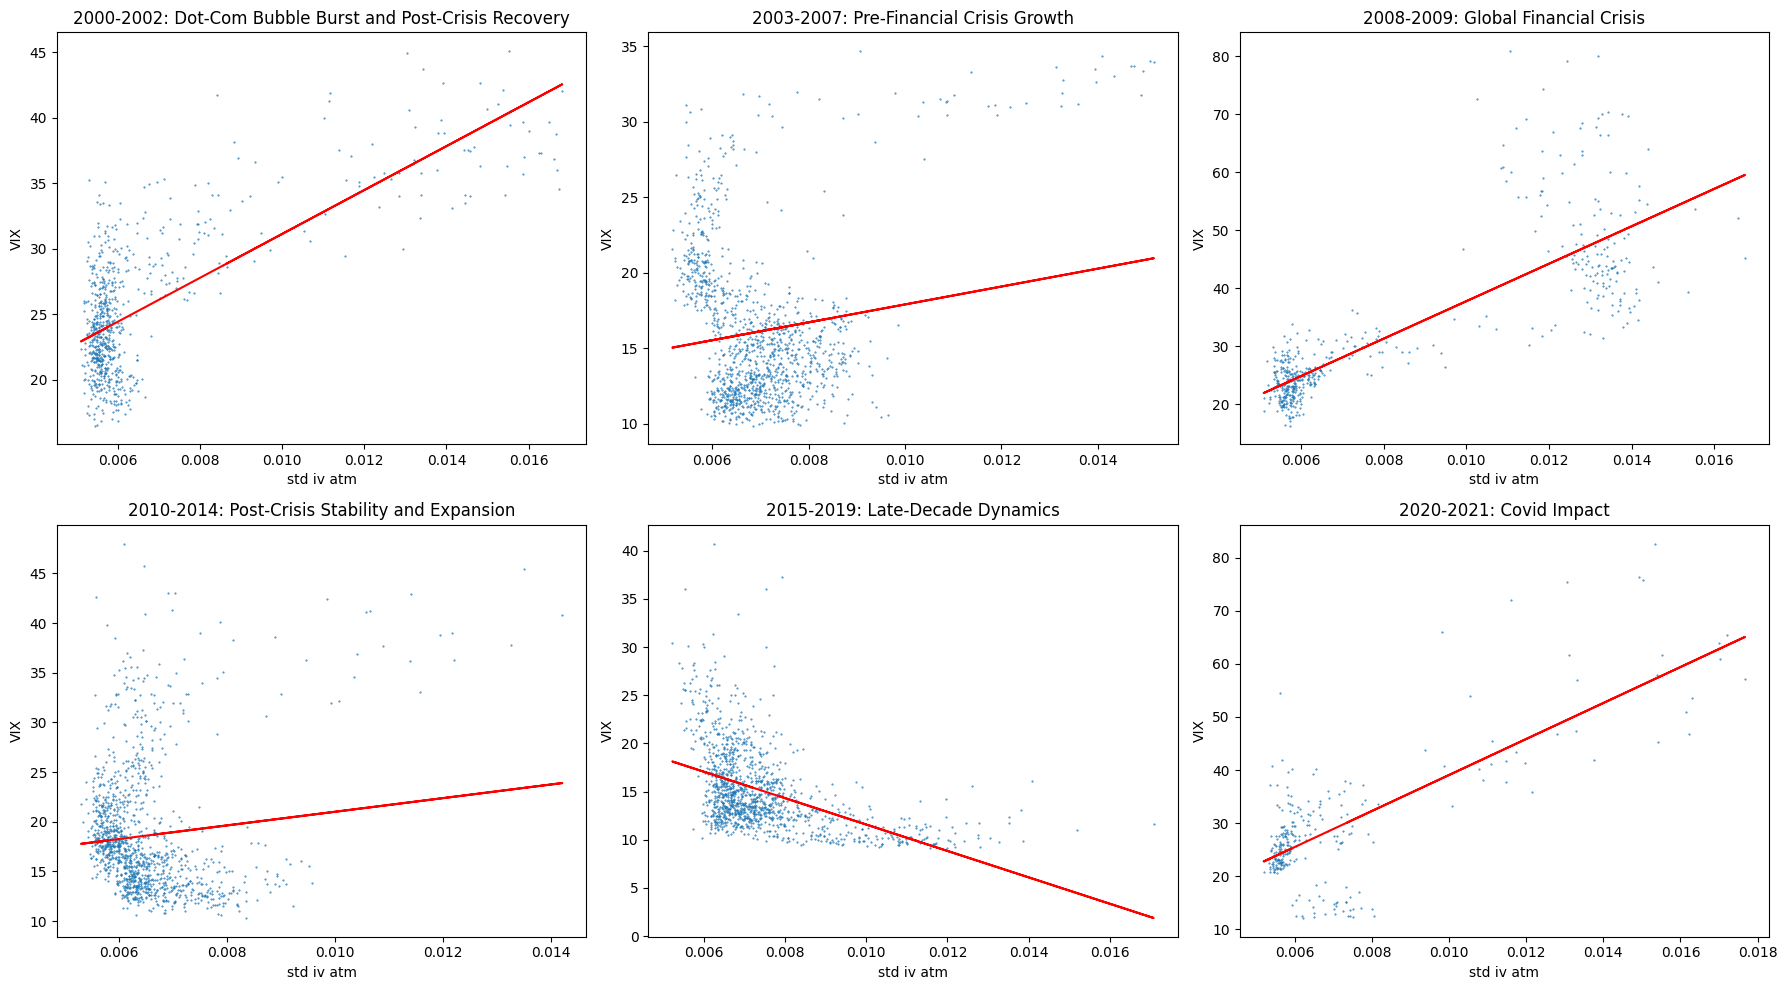

In [5]:
spx_df = pd.read_parquet("data/spx_with_vix.parquet")
spx_df["VIX"] = ((spx_df["VIX"])) # change this line to play with different linearization
for i in range(1, 11):
    spx_df[f"VIX_p{i}"] = spx_df["VIX"].shift(-i)
    spx_df[f"abs_delta_VIX_p{i}"] = np.abs(spx_df[f"VIX_p{i}"] - spx_df["VIX"].shift(1))
simulated_surfaces = np.load("test_spx/2023_08_27_simple/model_0_gen3.npy") # no ex feats
simulated_atm = simulated_surfaces[:, :, 3, 2]
simulated_atm_std = np.std(simulated_atm, axis=1)

regression_df = spx_df.loc[3:5303-1,
["date", "VIX", "delta_VIX", "abs_delta_VIX"] + [f"VIX_p{i}" for i in range(1, 11)] + [f"abs_delta_VIX_p{i}" for i in range(1, 11)]]
regression_df1 = regression_df.copy()
regression_df1["iv_atm_std"] = simulated_atm_std

fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 5 * num_rows))

# now each period
for i, (period_date, period_title, period_range) in enumerate(periods):
    row, col = divmod(i, num_cols)
    ax = axes[row, col]
    subset_df = regression_df1[regression_df1["date"].isin(period_range)]

    # Perform regression and prediction
    model = smf.ols(f"VIX~1+iv_atm_std", data=subset_df).fit(cov_type="HC3")
    y_pred = model.predict(subset_df)
    ax.plot(subset_df["iv_atm_std"], y_pred, color="red")
    ax.scatter(subset_df["iv_atm_std"], subset_df["VIX"], s=0.2)
    ax.set_xlabel("std iv atm")
    ax.set_ylabel("VIX")
    ax.set_title(f"{period_date}: {period_title}")

plt.tight_layout()
plt.show()

In [6]:
# Loop through each period
for y in ["VIX", "abs_delta_VIX"]:
    models = []
    model_names = []
    for period_date, period_title, period_range in periods:
        subset_df = regression_df1[regression_df1["date"].isin(period_range)]
        model = smf.ols(f"{y}~1+iv_atm_std", data=subset_df).fit(cov_type="HC3")
        models.append(model)
        model_names.append(f"{period_date}_{y}")

    sm = summary_col(models, model_names=model_names, stars=True,
                    regressor_order=["iv_atm_std", "Intercept"],
                    info_dict={'$N$':lambda x: "{0:d}".format(int(x.nobs))})
    with open(f"tables/no_ex/reg_rolling_no_ex_std_{y}.tex", "w") as f:
        f.write(latex_format(sm))

## mean

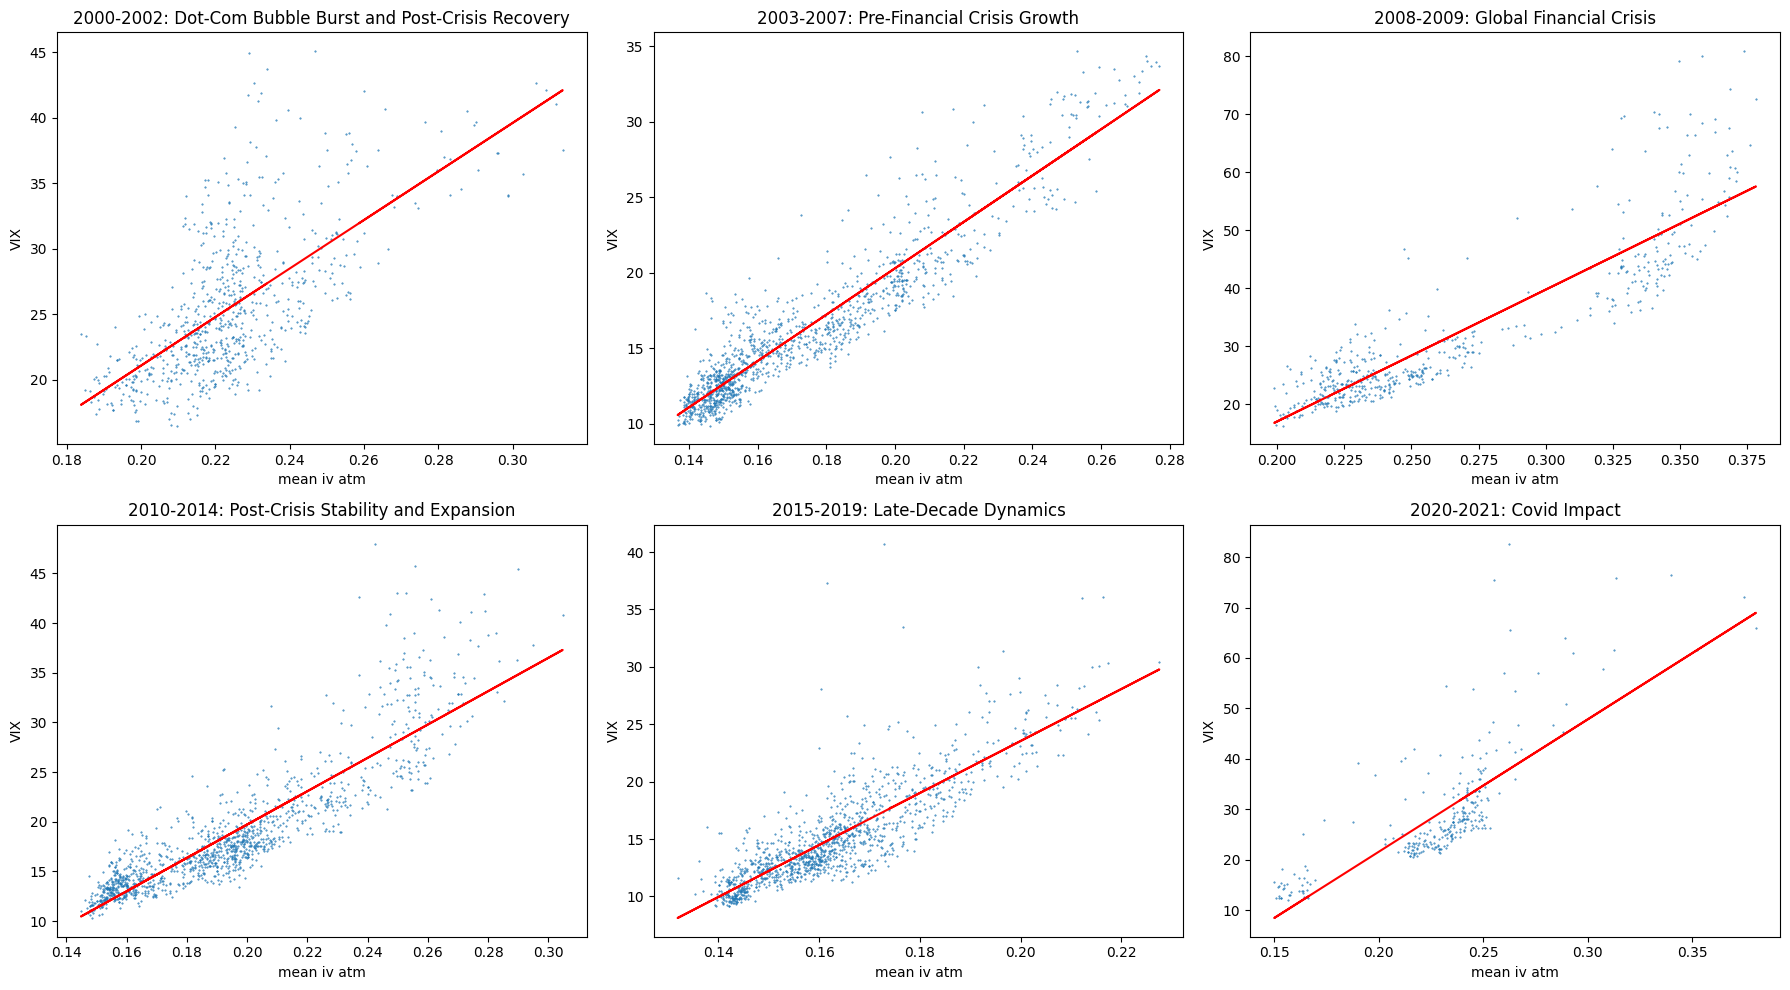

In [7]:
spx_df = pd.read_parquet("data/spx_with_vix.parquet")
spx_df["VIX"] = ((spx_df["VIX"])) # change this line to play with different linearization
for i in range(1, 11):
    spx_df[f"VIX_p{i}"] = spx_df["VIX"].shift(-i)
    spx_df[f"abs_delta_VIX_p{i}"] = np.abs(spx_df[f"VIX_p{i}"] - spx_df["VIX"].shift(1))
simulated_surfaces = np.load("test_spx/2023_08_27_simple/model_0_gen3.npy") # no ex feats
simulated_atm = simulated_surfaces[:, :, 3, 2]
simulated_atm_mean = np.mean(simulated_atm, axis=1)

regression_df = spx_df.loc[3:5303-1,
["date", "VIX", "delta_VIX", "abs_delta_VIX"] + [f"VIX_p{i}" for i in range(1, 11)] + [f"abs_delta_VIX_p{i}" for i in range(1, 11)]]
regression_df1 = regression_df.copy()
regression_df1["iv_atm_mean"] = simulated_atm_mean

fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 5 * num_rows))

# now each period
for i, (period_date, period_title, period_range) in enumerate(periods):
    row, col = divmod(i, num_cols)
    ax = axes[row, col]
    subset_df = regression_df1[regression_df1["date"].isin(period_range)]

    # Perform regression and prediction
    model = smf.ols(f"VIX~1+iv_atm_mean", data=subset_df).fit(cov_type="HC3")
    y_pred = model.predict(subset_df)
    ax.plot(subset_df["iv_atm_mean"], y_pred, color="red")
    ax.scatter(subset_df["iv_atm_mean"], subset_df["VIX"], s=0.2)
    ax.set_xlabel("mean iv atm")
    ax.set_ylabel("VIX")
    ax.set_title(f"{period_date}: {period_title}")

plt.tight_layout()
plt.show()

In [8]:
# Loop through each period
for y in ["VIX", "abs_delta_VIX"]:
    models = []
    model_names = []
    for period_date, period_title, period_range in periods:
        subset_df = regression_df1[regression_df1["date"].isin(period_range)]
        model = smf.ols(f"{y}~1+iv_atm_mean", data=subset_df).fit(cov_type="HC3")
        models.append(model)
        model_names.append(f"{period_date}_{y}")

    sm = summary_col(models, model_names=model_names, stars=True,
                    regressor_order=["iv_atm_mean", "Intercept"],
                    info_dict={'$N$':lambda x: "{0:d}".format(int(x.nobs))})
    with open(f"tables/no_ex/reg_rolling_no_ex_mean_{y}.tex", "w") as f:
        f.write(latex_format(sm))

# Regression - no loss on ret

## std

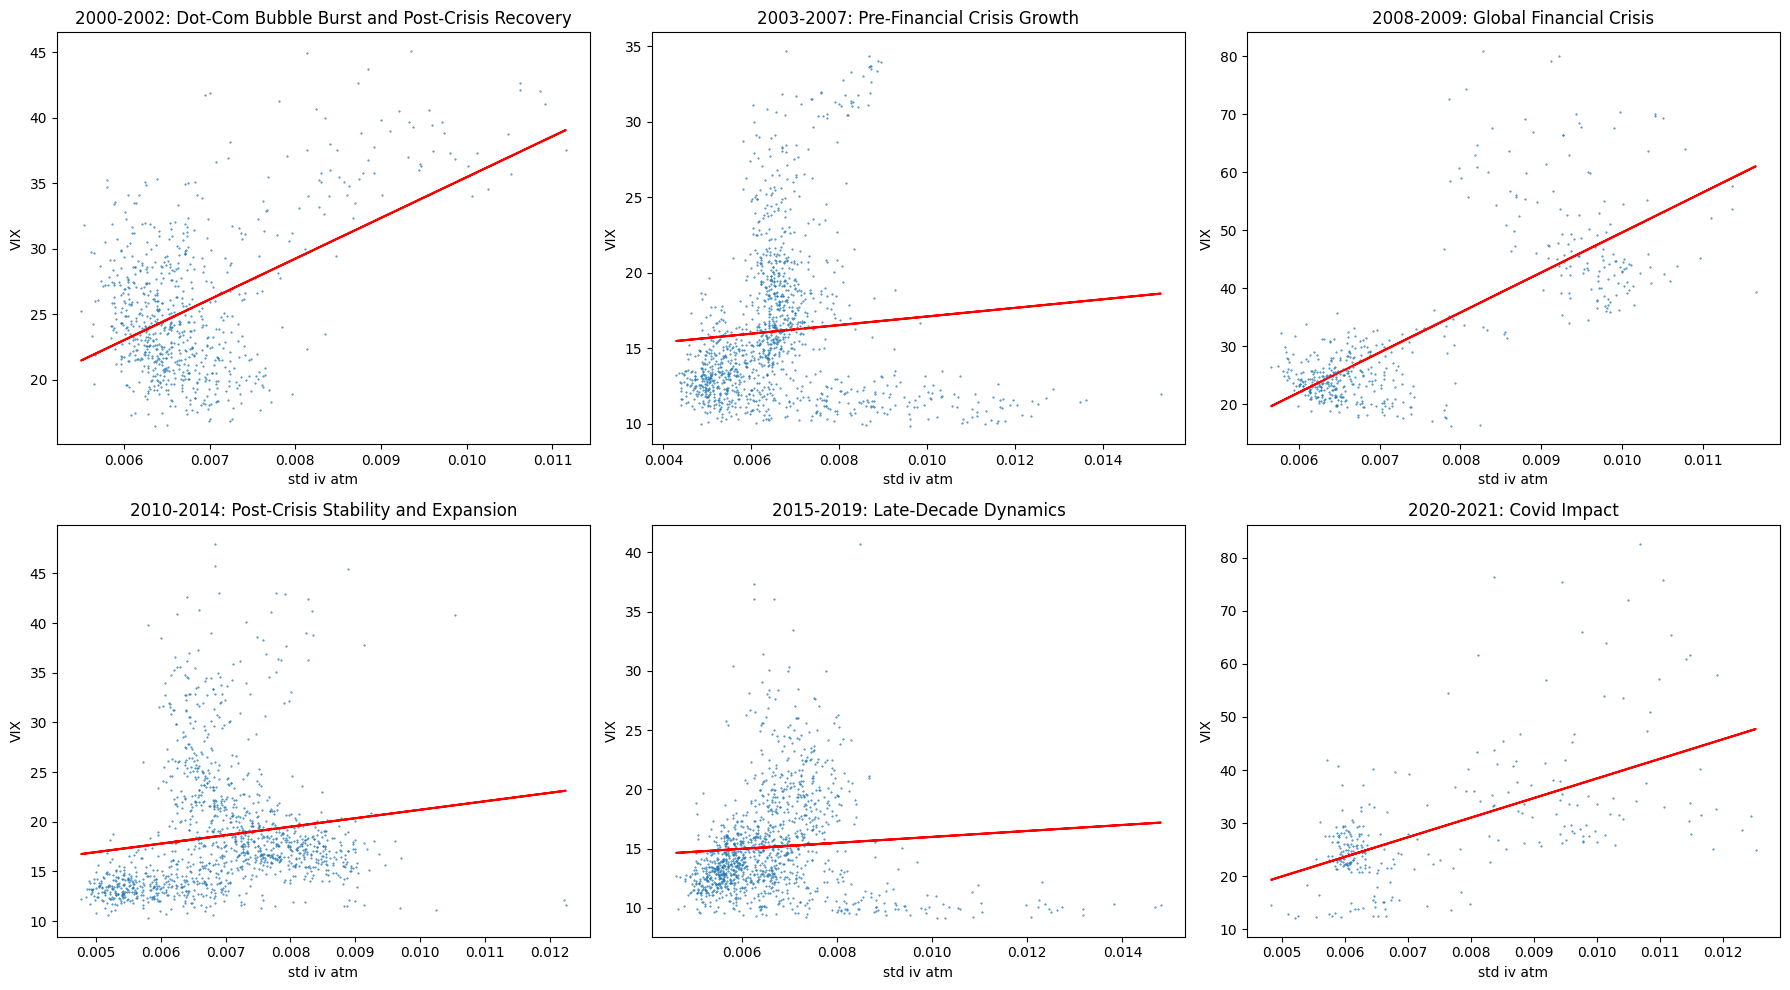

In [9]:
spx_df = pd.read_parquet("data/spx_with_vix.parquet")
spx_df["VIX"] = ((spx_df["VIX"])) # change this line to play with different linearization
for i in range(1, 11):
    spx_df[f"VIX_p{i}"] = spx_df["VIX"].shift(-i)
    spx_df[f"abs_delta_VIX_p{i}"] = np.abs(spx_df[f"VIX_p{i}"] - spx_df["VIX"].shift(1))
simulated_surfaces = np.load("test_spx/2023_08_27/model_0_gen3.npy") # no loss on ret
simulated_atm = simulated_surfaces[:, :, 3, 2]
simulated_atm_std = np.std(simulated_atm, axis=1)

regression_df = spx_df.loc[3:5303-1,
["date", "VIX", "delta_VIX", "abs_delta_VIX"] + [f"VIX_p{i}" for i in range(1, 11)] + [f"abs_delta_VIX_p{i}" for i in range(1, 11)]]
regression_df1 = regression_df.copy()
regression_df1["iv_atm_std"] = simulated_atm_std

fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 5 * num_rows))

# now each period
for i, (period_date, period_title, period_range) in enumerate(periods):
    row, col = divmod(i, num_cols)
    ax = axes[row, col]
    subset_df = regression_df1[regression_df1["date"].isin(period_range)]

    # Perform regression and prediction
    model = smf.ols(f"VIX~1+iv_atm_std", data=subset_df).fit(cov_type="HC3")
    y_pred = model.predict(subset_df)
    ax.plot(subset_df["iv_atm_std"], y_pred, color="red")
    ax.scatter(subset_df["iv_atm_std"], subset_df["VIX"], s=0.2)
    ax.set_xlabel("std iv atm")
    ax.set_ylabel("VIX")
    ax.set_title(f"{period_date}: {period_title}")

plt.tight_layout()
plt.show()

In [10]:
# Loop through each period
for y in ["VIX", "abs_delta_VIX"]:
    models = []
    model_names = []
    for period_date, period_title, period_range in periods:
        subset_df = regression_df1[regression_df1["date"].isin(period_range)]
        model = smf.ols(f"{y}~1+iv_atm_std", data=subset_df).fit(cov_type="HC3")
        models.append(model)
        model_names.append(f"{period_date}_{y}")

    sm = summary_col(models, model_names=model_names, stars=True,
                    regressor_order=["iv_atm_std", "Intercept"],
                    info_dict={'$N$':lambda x: "{0:d}".format(int(x.nobs))})
    with open(f"tables/no_loss/reg_rolling_no_loss_std_{y}.tex", "w") as f:
        f.write(latex_format(sm))

## mean

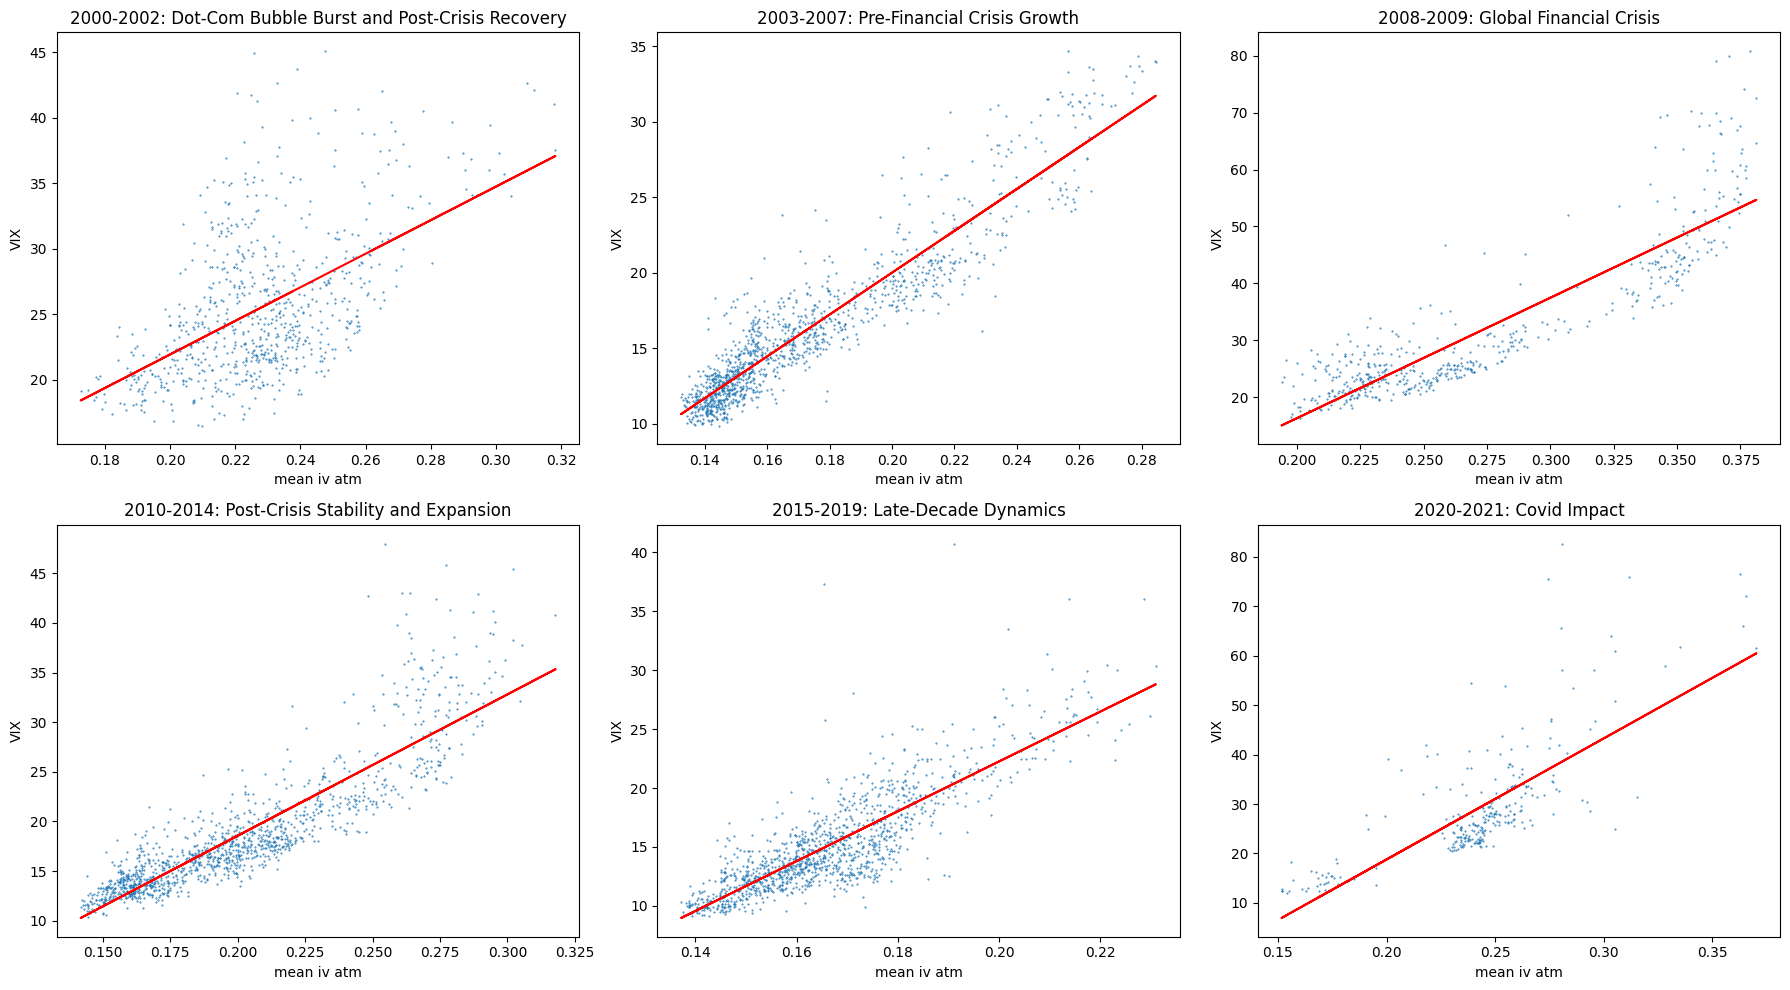

In [11]:
spx_df = pd.read_parquet("data/spx_with_vix.parquet")
spx_df["VIX"] = ((spx_df["VIX"])) # change this line to play with different linearization
for i in range(1, 11):
    spx_df[f"VIX_p{i}"] = spx_df["VIX"].shift(-i)
    spx_df[f"abs_delta_VIX_p{i}"] = np.abs(spx_df[f"VIX_p{i}"] - spx_df["VIX"].shift(1))
simulated_surfaces = np.load("test_spx/2023_08_27/model_0_gen3.npy") # no loss on ret
simulated_atm = simulated_surfaces[:, :, 3, 2]
simulated_atm_mean = np.mean(simulated_atm, axis=1)

regression_df = spx_df.loc[3:5303-1,
["date", "VIX", "delta_VIX", "abs_delta_VIX"] + [f"VIX_p{i}" for i in range(1, 11)] + [f"abs_delta_VIX_p{i}" for i in range(1, 11)]]
regression_df1 = regression_df.copy()
regression_df1["iv_atm_mean"] = simulated_atm_mean

fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 5 * num_rows))

# now each period
for i, (period_date, period_title, period_range) in enumerate(periods):
    row, col = divmod(i, num_cols)
    ax = axes[row, col]
    subset_df = regression_df1[regression_df1["date"].isin(period_range)]

    # Perform regression and prediction
    model = smf.ols(f"VIX~1+iv_atm_mean", data=subset_df).fit(cov_type="HC3")
    y_pred = model.predict(subset_df)
    ax.plot(subset_df["iv_atm_mean"], y_pred, color="red")
    ax.scatter(subset_df["iv_atm_mean"], subset_df["VIX"], s=0.2)
    ax.set_xlabel("mean iv atm")
    ax.set_ylabel("VIX")
    ax.set_title(f"{period_date}: {period_title}")

plt.tight_layout()
plt.show()

In [12]:
# Loop through each period
for y in ["VIX", "abs_delta_VIX"]:
    models = []
    model_names = []
    for period_date, period_title, period_range in periods:
        subset_df = regression_df1[regression_df1["date"].isin(period_range)]
        model = smf.ols(f"{y}~1+iv_atm_mean", data=subset_df).fit(cov_type="HC3")
        models.append(model)
        model_names.append(f"{period_date}_{y}")

    sm = summary_col(models, model_names=model_names, stars=True,
                    regressor_order=["iv_atm_mean", "Intercept"],
                    info_dict={'$N$':lambda x: "{0:d}".format(int(x.nobs))})
    with open(f"tables/no_loss/reg_rolling_no_loss_mean_{y}.tex", "w") as f:
        f.write(latex_format(sm))

# Regression - loss on ret

## std

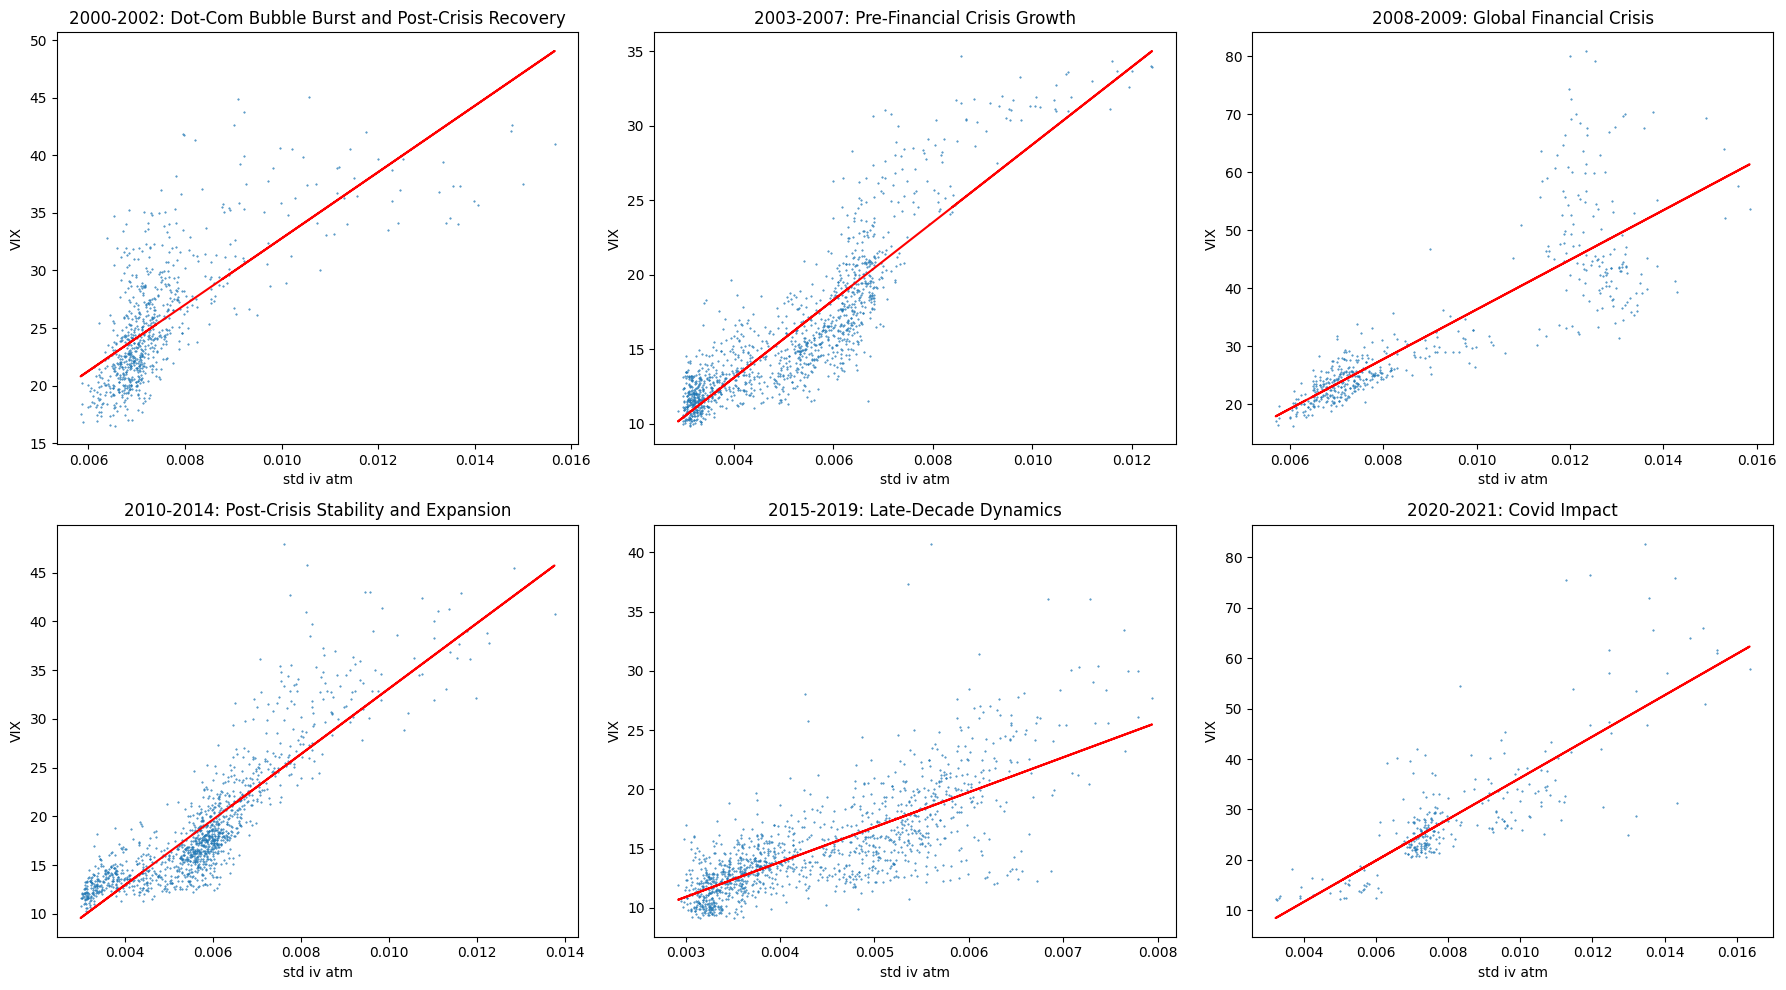

In [13]:
spx_df = pd.read_parquet("data/spx_with_vix.parquet")
spx_df["VIX"] = ((spx_df["VIX"])) # change this line to play with different linearization
for i in range(1, 11):
    spx_df[f"VIX_p{i}"] = spx_df["VIX"].shift(-i)
    spx_df[f"abs_delta_VIX_p{i}"] = np.abs(spx_df[f"VIX_p{i}"] - spx_df["VIX"].shift(1))
simulation = np.load("test_spx/2023_08_27/model_1_gen3.npz") # loss on ret
simulated_surfaces = simulation["surfaces"]
simulated_atm = simulated_surfaces[:, :, 3, 2]
simulated_atm_std = np.std(simulated_atm, axis=1)

regression_df = spx_df.loc[3:5303-1,
["date", "VIX", "delta_VIX", "abs_delta_VIX"] + [f"VIX_p{i}" for i in range(1, 11)] + [f"abs_delta_VIX_p{i}" for i in range(1, 11)]]
regression_df1 = regression_df.copy()
regression_df1["iv_atm_std"] = simulated_atm_std

fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 5 * num_rows))

# now each period
for i, (period_date, period_title, period_range) in enumerate(periods):
    row, col = divmod(i, num_cols)
    ax = axes[row, col]
    subset_df = regression_df1[regression_df1["date"].isin(period_range)]

    # Perform regression and prediction
    model = smf.ols(f"VIX~1+iv_atm_std", data=subset_df).fit(cov_type="HC3")
    y_pred = model.predict(subset_df)
    ax.plot(subset_df["iv_atm_std"], y_pred, color="red")
    ax.scatter(subset_df["iv_atm_std"], subset_df["VIX"], s=0.2)
    ax.set_xlabel("std iv atm")
    ax.set_ylabel("VIX")
    ax.set_title(f"{period_date}: {period_title}")

plt.tight_layout()
plt.show()

In [14]:
# Loop through each period
for y in ["VIX", "abs_delta_VIX"]:
    models = []
    model_names = []
    for period_date, period_title, period_range in periods:
        subset_df = regression_df1[regression_df1["date"].isin(period_range)]
        model = smf.ols(f"{y}~1+iv_atm_std", data=subset_df).fit(cov_type="HC3")
        models.append(model)
        model_names.append(f"{period_date}_{y}")

    sm = summary_col(models, model_names=model_names, stars=True,
                    regressor_order=["iv_atm_std", "Intercept"],
                    info_dict={'$N$':lambda x: "{0:d}".format(int(x.nobs))})
    with open(f"tables/loss/reg_rolling_loss_std_{y}.tex", "w") as f:
        f.write(latex_format(sm))

## mean

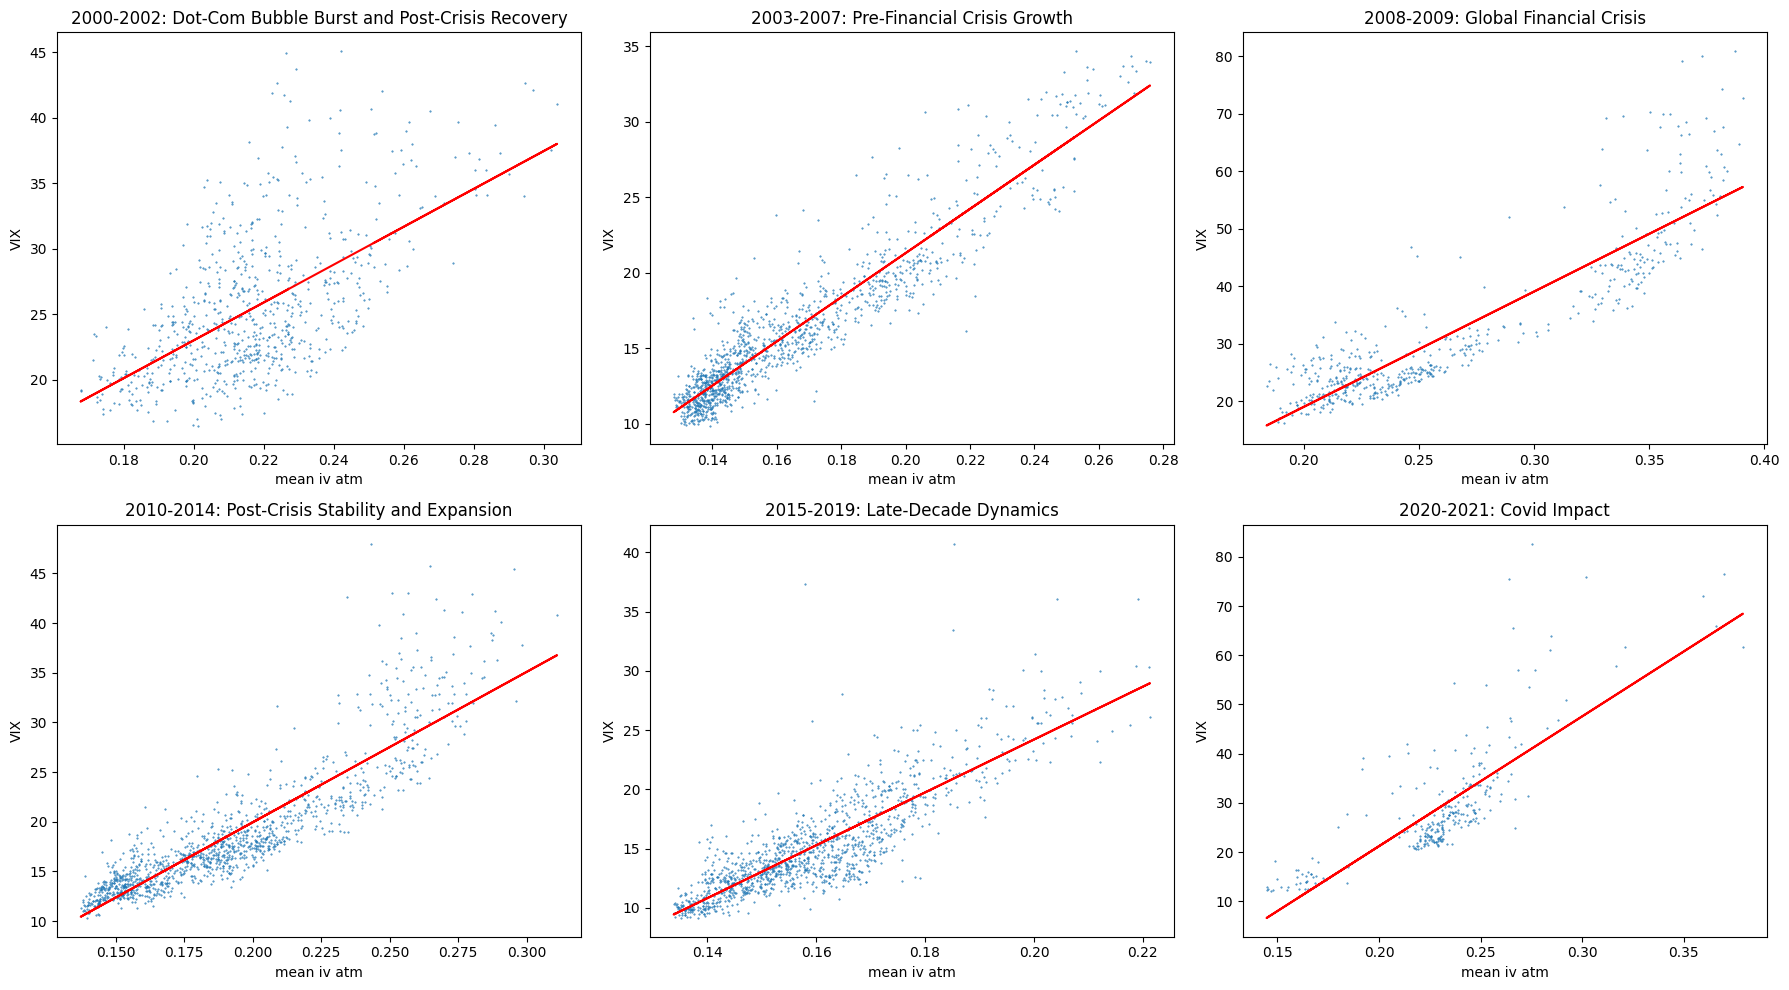

In [15]:
spx_df = pd.read_parquet("data/spx_with_vix.parquet")
spx_df["VIX"] = ((spx_df["VIX"])) # change this line to play with different linearization
for i in range(1, 11):
    spx_df[f"VIX_p{i}"] = spx_df["VIX"].shift(-i)
    spx_df[f"abs_delta_VIX_p{i}"] = np.abs(spx_df[f"VIX_p{i}"] - spx_df["VIX"].shift(1))
simulation = np.load("test_spx/2023_08_27/model_1_gen3.npz") # loss on ret
simulated_surfaces = simulation["surfaces"]
simulated_atm = simulated_surfaces[:, :, 3, 2]
simulated_atm_mean = np.mean(simulated_atm, axis=1)

regression_df = spx_df.loc[3:5303-1,
["date", "VIX", "delta_VIX", "abs_delta_VIX"] + [f"VIX_p{i}" for i in range(1, 11)] + [f"abs_delta_VIX_p{i}" for i in range(1, 11)]]
regression_df1 = regression_df.copy()
regression_df1["iv_atm_mean"] = simulated_atm_mean

fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 5 * num_rows))

# now each period
for i, (period_date, period_title, period_range) in enumerate(periods):
    row, col = divmod(i, num_cols)
    ax = axes[row, col]
    subset_df = regression_df1[regression_df1["date"].isin(period_range)]

    # Perform regression and prediction
    model = smf.ols(f"VIX~1+iv_atm_mean", data=subset_df).fit(cov_type="HC3")
    y_pred = model.predict(subset_df)
    ax.plot(subset_df["iv_atm_mean"], y_pred, color="red")
    ax.scatter(subset_df["iv_atm_mean"], subset_df["VIX"], s=0.2)
    ax.set_xlabel("mean iv atm")
    ax.set_ylabel("VIX")
    ax.set_title(f"{period_date}: {period_title}")

plt.tight_layout()
plt.show()

In [16]:
# Loop through each period
for y in ["VIX", "abs_delta_VIX"]:
    models = []
    model_names = []
    for period_date, period_title, period_range in periods:
        subset_df = regression_df1[regression_df1["date"].isin(period_range)]
        model = smf.ols(f"{y}~1+iv_atm_mean", data=subset_df).fit(cov_type="HC3")
        models.append(model)
        model_names.append(f"{period_date}_{y}")

    sm = summary_col(models, model_names=model_names, stars=True,
                    regressor_order=["iv_atm_mean", "Intercept"],
                    info_dict={'$N$':lambda x: "{0:d}".format(int(x.nobs))})
    with open(f"tables/loss/reg_rolling_loss_mean_{y}.tex", "w") as f:
        f.write(latex_format(sm))